# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке.

Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

#### Признаки
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

#### Целевой признак
- *Exited* — факт ухода клиента

## Оглавление

1. [Подготовка данных](#step1)
2. [Исследование задачи](#step2)
3. [Борьба с дисбалансом](#step3)
4. [Тестирование модели](#step4)
5. [Общий вывод](#step5)

<a id="step1"></a>
## 1. Подготовка данных

### Предобработка данных

In [1]:
# Подключение библиотек, необходимых модулей и алгоритмов
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from IPython.display import display
from warnings import simplefilter

In [2]:
# прочитаем данные из файла и выведем первые 10 строк
clients = pd.read_csv('Churn.csv')
clients.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# выведем названия столбцов таблицы
clients.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Видно, что названия столбцов состоят только из латинских символов и не содержат лишних пробелов в начале и в конце. Однако, они содержат заглавые буквы. Переведем названия в нижний регистр, а чтобы отделить слова, поставим между ними нижнее подчеркивание.

In [4]:
# получаем новые названия, проставляя знак '_' перед каждой неначальной заглавной буквой
new_columns = list(map(lambda x: re.sub(r'(\B[A-Z])', r'_\1', x), clients.columns.values))

In [5]:
# приведем все буквы к нижнему регистру
new_columns = list(map(str.lower, new_columns))

In [6]:
# поменяем названия в исходной таблице
clients.columns = new_columns
clients.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Проверим, есть ли пустые значения в таблице.

In [7]:
clients.isnull().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [8]:
clients['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Пустые значения только в столбце `tenure` (количество недвижимости у клиента). Скорее всего, если значение пустое, то это означает, что клиент его не заполнил и у него нет недвижимости. Заменим пропущенные строки случайным 0.

In [9]:
clients.loc[clients['tenure'].isnull(), 'tenure'] = 0

In [10]:
# проверим внесенные изменения
clients.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

Здесь же посмотрим, какие значения теперь хранятся в этом столбце. Изначально здесь был определен тип данных, как вещественные числа. Возможно, это было из-за присутсвия в этом столбце значение NaN.

In [11]:
clients.info()
print()
clients['tenure'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB



0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

Действительно, здесь могут хранится только целочисленные значения.

In [12]:
clients['tenure'] = clients['tenure'].astype(int)

Проверим таблицу на наличие дубликатов. Но сначала приведем все данные к нижнему регистру. Для этого необходимо посмотреть, где хранятся строковые значения.

In [13]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int32  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB


Как видно из общей информации о таблице типы данных для столбцов определены правильно, где должны находиться числа - определены числовые типы данных, где строки - строки.
Теперь приведем значения в столбцах `surname`, `geography`, `gender` к нижнему регистру.

In [14]:
check_cols = ['surname', 'geography', 'gender']
for cur_col in check_cols:
    clients[cur_col] = clients[cur_col].str.lower()

In [15]:
clients.duplicated().sum()

0

Полностью дублирующих строк с таблице нет.

### Подготовка признаков

Сразу же, выделим отдельно наш целевой признак. Далее в этом пункте будем подготавливать только оставшиеся признаки.

In [16]:
target = clients['exited']
features = clients.drop('exited', axis=1)

In [17]:
# Просмотрим признаки таблицу
features.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,1,15634602,hargrave,619,france,female,42,2,0.00,1,1,1,101348.88
1,2,15647311,hill,608,spain,female,41,1,83807.86,1,0,1,112542.58
2,3,15619304,onio,502,france,female,42,8,159660.80,3,1,0,113931.57
3,4,15701354,boni,699,france,female,39,1,0.00,2,0,0,93826.63
4,5,15737888,mitchell,850,spain,female,43,2,125510.82,1,1,1,79084.10


Можно заметить, что в наших признаках есть столбец `row_number` (индекс строки в данных). Логически он не несет какой-либо важной информации, и похоже он унаследовался при выгрузке данных для анализа. Посмотрим сколько здесь значений, а также максимальное и минимальное значения.

In [18]:
print('Column "row_number":')
print('\t Unique values:', features['row_number'].unique())
print('\t Total count:', features['row_number'].count())
print('\t Min row_number:', features['row_number'].min())
print('\t Max row_number:', features['row_number'].max())

Column "row_number":
	 Unique values: [    1     2     3 ...  9998  9999 10000]
	 Total count: 10000
	 Min row_number: 1
	 Max row_number: 10000


Исходя из полученной информации, видно, что значений столько же, сколько и строк. Судя по названию, эти значения действительно означают только номера строк, начиная с 1. Поэтому можно удалить данный столбец, его не стоит учитывать при обучении.

In [19]:
features = features.drop('row_number', axis=1)

Похожая ситуация со столбцом `customer_id` (уникальный идентификатор клиента). Посмотрим сколько уникальных значений в этом столбце.

In [20]:
print('Column "customer_id":')
print('\t Total count:', features['customer_id'].count())

Column "customer_id":
	 Total count: 10000


Значений столько же, сколько и строк в таблице. Данная информация также не поможет при обучении - удалим столбец.

In [21]:
features = features.drop('customer_id', axis=1)

Столбец с фамилиями также не несет важной информации для дальнейшего анализа. Исходя из уникальных идентификаторов клиентов, мы убедились, что клиенты даже с одинаковыми фамилиями - это разные люди. Удалим этот столбец.

In [22]:
features = features.drop('surname', axis=1)

Преобразуем наши категориальные переменные в количественные методом прямого отображения (One-Hot Encoding). Мы выбрали именно этот метод, потому что, к примеру, у нас есть столбец `gender` (пол), и если мы будем работать с логистической регрессией, мы будем обрабатывать значения полов, как числа. Допустим складывать их, а это лишено логического смысла.<br/>
Также учтем, что мы не хотим попасть в дамми-ловушку. Для это добавим дополнительный аргумент в функцию.

In [23]:
features = pd.get_dummies(features, drop_first=True)

In [24]:
# Просмотрим полученную таблицу
features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


Видно, что значения признаков в разных столбцах разных порядков. Это помешает при обучении. Чтобы решить данную проблему, масштабируем числовые данные методом стандартизации.

Для начала поймем, какие данные необходимо стандартизировать. Из всех оставшихся первоначальных столбцов отдельно стоит проверить стоблцы `has_cr_card` (наличие кредитной карты) и `is_active_member` (активность клиента), так как по описанию они похожи на бинарные признаки (0 или 1). А также столбцы `tenure` и `num_of_products`, их также можно интерпретировать как категориальные.

In [25]:
print(features['has_cr_card'].value_counts())
print()
print(features['is_active_member'].value_counts())
print()
print(features['tenure'].value_counts())
print()
print(features['num_of_products'].value_counts())

1    7055
0    2945
Name: has_cr_card, dtype: int64

1    5151
0    4849
Name: is_active_member, dtype: int64

0     1291
1      952
2      950
8      933
3      928
5      927
7      925
4      885
9      882
6      881
10     446
Name: tenure, dtype: int64

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64


Действительно, эти признаки категориальные. Не будем их рассматривать при стандартизации. Для остальных выполним масштабирование. Однако, сделаем это позже, после разделения данных на выборки.

### Вывод

На данном этапе мы загрузили и подготовили данные. Ознакомились с первоначальными данными, сохранили их в переменной `clients`. Далее последовал этап предобработки данных, мы проверили названия столбцов и привели их к подобающему виду. Далее была проведена проверка на пустые значения, соответствие типам данных и дубликаты. После проводилась подготовка признаков для алгоритмов машинного обучения. Были удалены столбцы, которые не должны повлиять на логику обучения, методом прямого кодирования мы избавились от категориальных переменных.

<a id="step2"></a>
## 2. Исследование задачи

В данном пункте необходимо провести исследование баланса классов и обучить модель без учёта дисбаланса.

Здесь и далее, нам понадобится параметр рандомизации, чтобы работать с одним и тем же распределением данных. Определим этот параметр и сохраним его в переменной `rand_seed`.

In [26]:
rand_seed = 12345

Для начала, разделим наши данные на выборки: обучающую, валидационую и тестовую в соотношении 3:1:1. Доли валидационной и тестовой выборок будут равны и составлять по 20 %. Поскольку функция train_test_split делит только на 2 выборки, мы разделим данные в 2 этапа - сначала 3:2,а затем вторую часть данных пополам. Чтобы доли классов 0 и 1 в разных выборках были одинаковыми, используем параметр стратификации в методе train_test_split.

In [27]:
# отделим 40% данных для проверочных выборок
features_train, features_check, target_train, target_check = train_test_split(
    features, target, test_size=0.4, random_state=rand_seed, stratify=target)

In [28]:
# определим 50% данных для валидационной выборки и 50% для тестовой выборки (из проверочное выборки)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_check, target_check, test_size=0.5, random_state=rand_seed, stratify=target_check)

In [29]:
# Проверим, что данные распределены правильно
print('Training:')
print('\t features shape:', features_train.shape)
print('\t target shape:', target_train.shape)

print('Validation:')
print('\t features shape:', features_valid.shape)
print('\t target shape:', target_valid.shape)

print('Testing:')
print('\t features shape:', features_test.shape)
print('\t target shape:', target_test.shape)

Training:
	 features shape: (6000, 11)
	 target shape: (6000,)
Validation:
	 features shape: (2000, 11)
	 target shape: (2000,)
Testing:
	 features shape: (2000, 11)
	 target shape: (2000,)


Мы разделили данные на обучающую, валидационную и тестовую выборки. Теперь можно выполнить масштабирование.

In [30]:
numerical_cols = ['credit_score', 'age', 'balance', 'estimated_salary']

In [31]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numerical_cols])

features_train[numerical_cols] = scaler.transform(features_train[numerical_cols])
features_valid[numerical_cols] = scaler.transform(features_valid[numerical_cols])
features_test[numerical_cols] = scaler.transform(features_test[numerical_cols])

In [32]:
# проверим значения признаков
print('features_train:')
display(features_train.head())
print('features_valid')
display(features_valid.head())
print('features_test')
display(features_test.head())

features_train:


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
2837,-1.040434,0.953312,6,0.774657,1,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,0,1.910540,1,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,8,0.481608,2,0,1,1.422836,0,0,1
660,-0.184996,0.190726,0,0.088439,1,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,1,0.879129,1,1,0,0.113236,0,0,0


features_valid


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
6612,-1.524838,2.383160,3,1.011655,1,0,1,0.010275,0,0,0
519,0.587990,1.811221,6,0.213192,1,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,8,0.893896,1,1,0,-0.603508,0,0,0
3475,1.226991,-0.762506,4,-0.240363,2,1,1,-1.621460,0,0,1
2707,-0.133464,-0.095244,3,0.447305,1,0,0,0.338574,0,0,0


features_test


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
657,-0.504497,1.429928,1,0.873883,2,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,1,-1.219673,1,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,1,-1.219673,1,1,0,-1.374743,0,0,1
1551,0.825039,1.239281,7,-1.219673,2,0,1,0.382306,0,1,0
2344,0.660135,0.953312,4,0.267087,1,1,0,-1.613578,1,0,0


Рассмотрим какой баланс классов в обучающей выборке.

In [33]:
print(target_train.value_counts(normalize=True))

0    0.796333
1    0.203667
Name: exited, dtype: float64


Видно, что на данный момент здесь присутсвует явный дисбаланс классов. Отрицательных ответов почти 80%, в то время как положительных ответов всего 20%. Попробуем обучить модель на таких данных.

Сейчас необходимо исследовать различные модели с разными гиперпараметрами и выбрать ту, для которой F1-мера будет наибольшей. Также для каждого случая необходимо рассмотреть значение меры AUC-ROC.<br/>
Перед нами задача бинарной классификации. В качества моделей будем рассматривать решающее дерево, случайный лес и логистическую регрессию.

- Решающее дерево.<br/>
В качестве исследуемых гиперпараметров возьмем максимальную глубину дерева (`max_depth`) в диапазоне от 2 до 20. Сохраним модель и ее гиперпараметры для самой высокой F1-меры.

In [34]:
check_dtc_params = {'max_depth': range (2, 10, 1)}

In [35]:
# С помощью поиска по сетке (GridSearchCV) мы найдем параметры для наилучшей модели для критерия f1-меры
def find_best_dtc(rand_seed, check_class_weight, features_train, target_train):
    clf = DecisionTreeClassifier(class_weight=check_class_weight, random_state=rand_seed)

    grid = GridSearchCV(clf, check_dtc_params, cv=5, scoring='f1')
    grid.fit(features_train, target_train)

    best_dtc_depth = grid.best_params_['max_depth']
    
    return best_dtc_depth

In [36]:
%%time

check_class_weight = None
best_dtc_depth = find_best_dtc(rand_seed, check_class_weight, features_train, target_train)
print('best_dtc_depth =', best_dtc_depth)
print()

best_dtc_depth = 7

Wall time: 725 ms


In [37]:
# Измерим значение AUC-ROC
model = DecisionTreeClassifier(
        max_depth=best_dtc_depth,
        random_state=rand_seed
)
model.fit(features_train, target_train)

predicted_train = model.predict(features_train)
dtc_train_f1_score = f1_score(target_train, predicted_train)
print('dtc_train_f1_score =', dtc_train_f1_score)

predicted_valid = model.predict(features_valid)
dtc_valid_f1_score = f1_score(target_valid, predicted_valid)
print('dtc_valid_f1_score =', dtc_valid_f1_score)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
dtc_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('dtc_auc_roc =', dtc_auc_roc)

dtc_train_f1_score = 0.6115288220551378
dtc_valid_f1_score = 0.5924855491329479
dtc_auc_roc = 0.8247056360232534


- Случайный лес.<br/>
В качестве исследуемых гиперпараметров возьмем те же, что и для решающего дерева: `max_depth`. Также добавим исследование по количеству оценщиков (`n_estimators`), который будет изменяться в диапазоне от 50 до 150. Сохраним модель и ее гиперпараметры для самой высокой F1-меры.

In [38]:
check_rfc_params = {'n_estimators': range (50, 150, 10),
                    'max_depth': range (2, 40, 5)}

In [39]:
simplefilter(action='ignore', category=FutureWarning)

In [40]:
# С помощью поиска по сетке (GridSearchCV) мы найдем параметры для наилучшей модели для критерия f1-меры
def find_best_rfc(rand_seed, check_class_weight, features_train, target_train):
    clf = RandomForestClassifier(class_weight=check_class_weight, random_state=rand_seed)

    grid = GridSearchCV(clf, check_rfc_params, cv=5, scoring='f1')
    grid.fit(features_train, target_train)

    best_rfc_depth=grid.best_params_['max_depth']
    best_rfc_estimators=grid.best_params_['n_estimators']
    
    return best_rfc_depth, best_rfc_estimators

In [41]:
%%time


check_class_weight = None
best_rfc_depth, best_rfc_estimators = find_best_rfc(rand_seed, check_class_weight, features_train, target_train)
print('best_rfc_depth =', best_rfc_depth)
print('best_rfc_estimators =', best_rfc_estimators)
print()

best_rfc_depth = 22
best_rfc_estimators = 60

Wall time: 4min 6s


In [42]:
# Измерим значение AUC-ROC
model = RandomForestClassifier(
        n_estimators=best_rfc_estimators,
        max_depth=best_rfc_depth,
        random_state=rand_seed
)
model.fit(features_train, target_train)

predicted_train = model.predict(features_train)
rfc_train_f1_score = f1_score(target_train, predicted_train)
print('rfc_train_f1_score =', rfc_train_f1_score)

predicted_valid = model.predict(features_valid)
rfc_valid_f1_score = f1_score(target_valid, predicted_valid)
print('rfc_valid_f1_score =', rfc_valid_f1_score)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
rfc_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('rfc_auc_roc =', rfc_auc_roc)

rfc_train_f1_score = 0.9991809991809992
rfc_valid_f1_score = 0.6135693215339233
rfc_auc_roc = 0.8623725243866391


- Логистическая регрессия.<br/>
В данном случае рассмотрим работу модели для гиперпараметров по умолчанию.

In [43]:
# Измерим значение AUC-ROC
model = LogisticRegression(
        solver='liblinear',
        random_state=rand_seed
)
model.fit(features_train, target_train)

predicted_train = model.predict(features_train)
lr_train_f1_score = f1_score(target_train, predicted_train)
print('lr_train_f1_score =', lr_train_f1_score)

lr_predicted_valid = model.predict(features_valid)
lr_valid_f1_score = f1_score(target_valid, lr_predicted_valid)
print('lr_valid_f1_score =', lr_valid_f1_score)

lr_probabilities_valid = model.predict_proba(features_valid)
lr_probabilities_one_valid = lr_probabilities_valid[:, 1]
lr_auc_roc = roc_auc_score(target_valid, lr_probabilities_one_valid)
print('lr_auc_roc =', lr_auc_roc)

lr_train_f1_score = 0.3171912832929782
lr_valid_f1_score = 0.3076923076923077
lr_auc_roc = 0.7875498817617498


In [44]:
print('dtc_valid_f1_score =', dtc_valid_f1_score)
print('rfc_valid_f1_score =', rfc_valid_f1_score)
print('lr_valid_f1_score =', lr_valid_f1_score)

dtc_valid_f1_score = 0.5924855491329479
rfc_valid_f1_score = 0.6135693215339233
lr_valid_f1_score = 0.3076923076923077


### Вывод

На данном этап мы определили, что в наших данных присутсвует дисбаланс классов - отрицательных ответов много больше чем положительных (80 на 20). Для этих даных мы провели обучение различных моделей, подобрали гиперпараметры, чтобы значение f1-меры было наибольшим. Для каждой модели с наилучшим показателем мы посчитали значение AUC-ROC, чтобы понять как сильно наша модель отличается от случайной. Лучшее значение f1-меры (0.61357) удалось получить на модели случайного леса (глубина = 22, количество оценщиков = 60). Значение AUC-ROC для этой же модели равно 0.86237. Данное значение достаточно высокое. Оно показывает, что наша модель предсказывает лучше, чем для случайного алгоритма. Среднее гармоническое полноты и точности (f1-мера), также довольно высокое, что показывает, что качество прогноза положительного класса на хорошем уровне. Однако, значение f1-меры можно еще повысить, если попытаться устранить дисбаланс в ответах.<br>
Высокое значение AUC-ROC и высокое значение f1-меры говорит нам, что наша модель предсказывает качественно, и при других значениях порога классификации модель также будет это делать на высоком уровне.

<a id="step3"></a>
## 3. Борьба с дисбалансом

Как видно из исследования, в наших данных присутствует дисбаланс классов. Это влияет на наши модели и, соответственно, на качество обучения. Попробуем устранить дисбаланс путем увеличения выборки. Для этого напишем функцию.

In [45]:
def upsample(rand_seed, features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rand_seed)
    
    return features_upsampled, target_upsampled

Также попробуем разобраться с дисбалансом путем уменьшения выборки отрицательных ответов. Реализуем функцию

In [46]:
def downsample(rand_seed, features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rand_seed)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rand_seed)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rand_seed)
    
    return features_downsampled, target_downsampled

Модифицируем наши данные для тренировки. Увеличим количество положительных объектов в 4 раза, чтобы и отрицательных, и положительных было примерно поровну.

In [47]:
features_train_upsampled, target_train_upsampled = upsample(rand_seed, features_train, target_train, 4)

Уменьшим количество отрицательных объектов в 4 раза.

In [48]:
features_train_downsampled, target_train_downsampled = downsample(rand_seed, features_train, target_train, 0.25)

Проверим, как сейчас баланс объектов в тренировочной выборке.

In [49]:
print(target_train_upsampled.value_counts(normalize=True))

1    0.50569
0    0.49431
Name: exited, dtype: float64


In [50]:
print(target_train_downsampled.value_counts(normalize=True))

1    0.505795
0    0.494205
Name: exited, dtype: float64


Теперь проверим, как изменились наши лучшие показатели F1-меры. Для каждой модели также укажем параметр веса класса, это тоже поможет восполнить дисбаланс.

Первым опять рассмотрим дерево решений:

In [51]:
%%time


check_class_weight_b = 'balanced'
best_dtc_depth_up_b = find_best_dtc(rand_seed, check_class_weight_b, features_train_upsampled, target_train_upsampled)
print('best_dtc_depth_up_b =', best_dtc_depth_up_b)
print()

# проверка полученных значений
model = DecisionTreeClassifier(
        max_depth=best_dtc_depth_up_b,
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_upsampled, target_train_upsampled)

dtc_predicted_train_up = model.predict(features_train_upsampled)
dtc_train_up_f1_score = f1_score(target_train_upsampled, dtc_predicted_train_up)
print('dtc_train_up_f1_score =', dtc_train_up_f1_score)

dtc_predicted_up_valid = model.predict(features_valid)
dtc_valid_up_f1_score = f1_score(target_valid, dtc_predicted_up_valid)
print('dtc_valid_up_f1_score =', dtc_valid_up_f1_score)

dtc_probabilities_up_valid = model.predict_proba(features_valid)
dtc_probabilities_up_one_valid = dtc_probabilities_up_valid[:, 1]
dtc_auc_roc_up = roc_auc_score(target_valid, dtc_probabilities_up_one_valid)
print('dtc_auc_roc_up =', dtc_auc_roc_up)
print()

best_dtc_depth_up_b = 9

dtc_train_up_f1_score = 0.8471720818291215
dtc_valid_up_f1_score = 0.5424710424710425
dtc_auc_roc_up = 0.7832891479456104

Wall time: 1.22 s


In [52]:
%%time


check_class_weight_b = 'balanced'
best_dtc_depth_down_b = find_best_dtc(rand_seed, check_class_weight_b, features_train_downsampled, target_train_downsampled)
print('best_dtc_depth_down_b =', best_dtc_depth_down_b)
print()

# проверка полученных значений
model = DecisionTreeClassifier(
        max_depth=best_dtc_depth_down_b,
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_downsampled, target_train_downsampled)

dtc_predicted_train_down = model.predict(features_train_downsampled)
dtc_train_down_f1_score = f1_score(target_train_downsampled, dtc_predicted_train_down)
print('dtc_train_down_f1_score =', dtc_train_down_f1_score)

dtc_predicted_down_valid = model.predict(features_valid)
dtc_valid_down_f1_score = f1_score(target_valid, dtc_predicted_down_valid)
print('dtc_valid_down_f1_score =', dtc_valid_down_f1_score)

dtc_probabilities_down_valid = model.predict_proba(features_valid)
dtc_probabilities_down_one_valid = dtc_probabilities_down_valid[:, 1]
dtc_auc_roc_down = roc_auc_score(target_valid, dtc_probabilities_down_one_valid)
print('dtc_auc_roc_down =', dtc_auc_roc_down)
print()

best_dtc_depth_down_b = 6

dtc_train_down_f1_score = 0.8055207026348807
dtc_valid_down_f1_score = 0.5911602209944751
dtc_auc_roc_down = 0.8524300423687062

Wall time: 535 ms


Далее случайный лес. Также с применением уже написанной функции для поиска наилучшей модели.

In [53]:
%%time


check_class_weight_b = 'balanced'
best_rfc_depth_up_b, best_rfc_estimators_up_b = find_best_rfc(rand_seed, check_class_weight_b, 
                                                              features_train_upsampled, target_train_upsampled)
print('best_rfc_depth_up_b =', best_rfc_depth_up_b)
print('best_rfc_estimators_up_b =', best_rfc_estimators_up_b)
print()

# проверка полученных значений
model = RandomForestClassifier(
        n_estimators=best_rfc_estimators_up_b,
        max_depth=best_rfc_depth_up_b,
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_upsampled, target_train_upsampled)

rfc_predicted_train_up = model.predict(features_train_upsampled)
rfc_train_up_f1_score = f1_score(target_train_upsampled, rfc_predicted_train_up)
print('rfc_train_up_f1_score =', rfc_train_up_f1_score)

rfc_predicted_up_valid = model.predict(features_valid)
rfc_valid_up_f1_score = f1_score(target_valid, rfc_predicted_up_valid)
print('rfc_valid_up_f1_score =', rfc_valid_up_f1_score)

rfc_probabilities_up_valid = model.predict_proba(features_valid)
rfc_probabilities_up_one_valid = rfc_probabilities_up_valid[:, 1]
rfc_auc_roc_up = roc_auc_score(target_valid, rfc_probabilities_up_one_valid)
print('rfc_auc_roc_up =', rfc_auc_roc_up)
print()

best_rfc_depth_up_b = 22
best_rfc_estimators_up_b = 140

rfc_train_up_f1_score = 1.0
rfc_valid_up_f1_score = 0.6223404255319148
rfc_auc_roc_up = 0.8642584860577397

Wall time: 6min 33s


In [54]:
%%time


check_class_weight_b = 'balanced'
best_rfc_depth_down_b, best_rfc_estimators_down_b = find_best_rfc(rand_seed, check_class_weight_b, 
                                                                  features_train_downsampled, target_train_downsampled)
print('best_rfc_depth_down_b =', best_rfc_depth_down_b)
print('best_rfc_estimators_down_b =', best_rfc_estimators_down_b)
print()

# проверка полученных значений
model = RandomForestClassifier(
        n_estimators=best_rfc_estimators_down_b,
        max_depth=best_rfc_depth_down_b,
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_downsampled, target_train_downsampled)

rfc_predicted_train_down = model.predict(features_train_downsampled)
rfc_train_down_f1_score = f1_score(target_train_downsampled, rfc_predicted_train_down)
print('rfc_train_down_f1_score =', rfc_train_down_f1_score)

rfc_predicted_down_valid = model.predict(features_valid)
rfc_valid_down_f1_score = f1_score(target_valid, rfc_predicted_down_valid)
print('rfc_valid_down_f1_score =', rfc_valid_down_f1_score)

rfc_probabilities_down_valid = model.predict_proba(features_valid)
rfc_probabilities_down_one_valid = rfc_probabilities_down_valid[:, 1]
rfc_auc_roc_down = roc_auc_score(target_valid, rfc_probabilities_down_one_valid)
print('rfc_auc_roc_down =', rfc_auc_roc_down)
print()

best_rfc_depth_down_b = 7
best_rfc_estimators_down_b = 60

rfc_train_down_f1_score = 0.8378262729995722
rfc_valid_down_f1_score = 0.6304558680892337
rfc_auc_roc_down = 0.8682982929352644

Wall time: 2min 52s


Проверим логистическую регрессию на сбалансированных данных.

In [55]:
%%time


check_class_weight_b = 'balanced'
model = LogisticRegression(
        solver='liblinear',
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_upsampled, target_train_upsampled)

lr_predicted_up_valid = model.predict(features_valid)
lr_valid_up_f1_score = f1_score(target_valid, lr_predicted_up_valid)
print('lr_valid_up_f1_score =', lr_valid_up_f1_score)

lr_probabilities_up_valid = model.predict_proba(features_valid)
lr_probabilities_up_one_valid = lr_probabilities_up_valid[:, 1]
lr_auc_roc_up = roc_auc_score(target_valid, lr_probabilities_up_one_valid)
print('lr_auc_roc_up =', lr_auc_roc_up)

lr_valid_up_f1_score = 0.5289982425307558
lr_auc_roc_up = 0.7937573898906297
Wall time: 44.9 ms


In [56]:
%%time


check_class_weight_b = 'balanced'
model = LogisticRegression(
        solver='liblinear',
        class_weight=check_class_weight_b,
        random_state=rand_seed
)
model.fit(features_train_downsampled, target_train_downsampled)

lr_predicted_down_valid = model.predict(features_valid)
lr_valid_down_f1_score = f1_score(target_valid, lr_predicted_down_valid)
print('lr_valid_down_f1_score =', lr_valid_down_f1_score)

lr_probabilities_down_valid = model.predict_proba(features_valid)
lr_probabilities_down_one_valid = lr_probabilities_down_valid[:, 1]
lr_auc_roc_down = roc_auc_score(target_valid, lr_probabilities_down_one_valid)
print('lr_auc_roc_down =', lr_auc_roc_down)

lr_valid_down_f1_score = 0.525217391304348
lr_auc_roc_down = 0.7927243447630309
Wall time: 32.9 ms


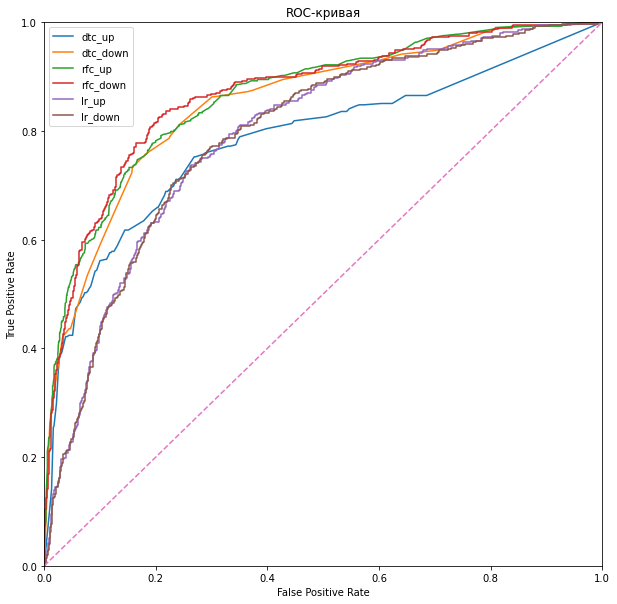

In [57]:
# Построим ROC-кривые

dtc_fpr_up, dtc_tpr_up, dtc_thresholds_up = roc_curve(target_valid, dtc_probabilities_up_one_valid)
dtc_fpr_down, dtc_tpr_down, dtc_thresholds_down = roc_curve(target_valid, dtc_probabilities_down_one_valid)

rfc_fpr_up, rfc_tpr_up, rfc_thresholds_up = roc_curve(target_valid, rfc_probabilities_up_one_valid)
rfc_fpr_down, rfc_tpr_down, rfc_thresholds_down = roc_curve(target_valid, rfc_probabilities_down_one_valid)

lr_fpr_up, lr_tpr_up, lr_thresholds_up = roc_curve(target_valid, lr_probabilities_up_one_valid)
lr_fpr_down, lr_tpr_down, lr_thresholds_down = roc_curve(target_valid, lr_probabilities_down_one_valid)

plt.figure(figsize=(10, 10))

# Наши ROC-кривая
plt.plot(dtc_fpr_up, dtc_tpr_up, label='dtc_up')
plt.plot(dtc_fpr_down, dtc_tpr_down, label='dtc_down')

plt.plot(rfc_fpr_up, rfc_tpr_up, label='rfc_up')
plt.plot(rfc_fpr_down, rfc_tpr_down, label='rfc_down')

plt.plot(lr_fpr_up, lr_tpr_up, label='lr_up')
plt.plot(lr_fpr_down, lr_tpr_down, label='lr_down')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.legend(loc='best')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

In [58]:
print('dtc_valid_up_f1_score =', dtc_valid_up_f1_score)
print('dtc_valid_down_f1_score =', dtc_valid_down_f1_score)
print()
print('rfc_valid_up_f1_score =', rfc_valid_up_f1_score)
print('rfc_valid_down_f1_score =', rfc_valid_down_f1_score)
print()
print('lr_valid_up_f1_score =', lr_valid_up_f1_score)
print('lr_valid_down_f1_score =', lr_valid_down_f1_score)

dtc_valid_up_f1_score = 0.5424710424710425
dtc_valid_down_f1_score = 0.5911602209944751

rfc_valid_up_f1_score = 0.6223404255319148
rfc_valid_down_f1_score = 0.6304558680892337

lr_valid_up_f1_score = 0.5289982425307558
lr_valid_down_f1_score = 0.525217391304348


### Вывод

На данном этапе мы устранили дисбаланс классов. Мы изменили параметр веса классов для каждой из моделей - сделали классы сбалансированными. Также мы рассмотрели варианты увеличения положительной выборки и уменьшения отрицательной. Применили их для каждой модели, использую ранее написанные функции для этого. В конечном счете, мы получили максимальное значение f1-меры 0,63046 на модели случаного леса (глубина = 7, количество оценщиков = 60) при уменьшении выборки отрицательных классов. Цель достичь показателя f1-меры на валидационной выборки выше 0.59 достигнута.<br>
Также были построены ROC-кривые для каждой из лучших моделей. На графике видно, что ROC-кривая для модели случайного леса при уменьшении выборки отрицательных классов находится ближе всего к 1. Что подтверждает, что данная модель является лучшей из представленных.

<a id="step4"></a>
## 4. Тестирование модели

Сейчас проверим нашу модель на тестовых данных. Применим, определенные ранее параметры к модели случайного леса на обучающих данных с уменьшенной выборкой отрицательных классов. Также учтем валидационные данные.

In [59]:
features_train_valid = pd.concat([features_train_downsampled] + [features_valid])
target_train_valid = pd.concat([target_train_downsampled] + [target_valid])

In [60]:
model = RandomForestClassifier(
        n_estimators=best_rfc_estimators_down_b,
        max_depth=best_rfc_depth_down_b,
        class_weight='balanced',
        random_state=rand_seed
)
model.fit(features_train_valid, target_train_valid)

predicted_test = model.predict(features_test)
rfc_test_f1_score = f1_score(target_test, predicted_test)
print('rfc_test_f1_score =', rfc_test_f1_score)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
rfc_test_auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('rfc_test_auc_roc =', rfc_test_auc_roc)

rfc_test_f1_score = 0.6036585365853658
rfc_test_auc_roc = 0.8539309725750402


<Figure size 576x576 with 0 Axes>

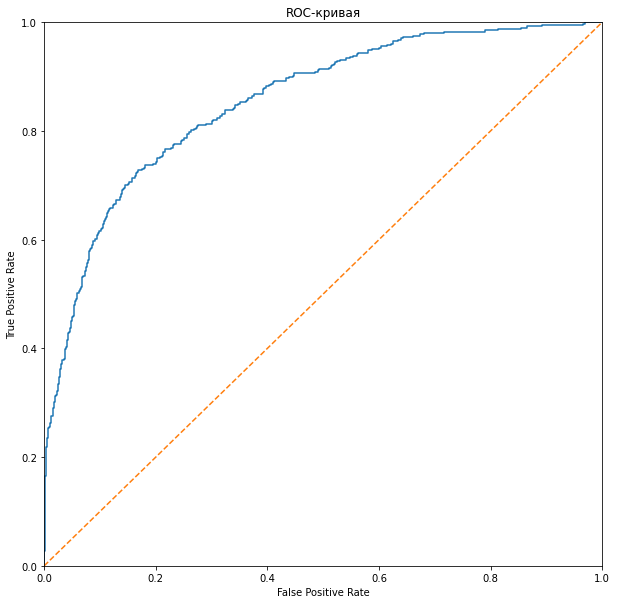

In [61]:
# Построим ROC-кривую

plt.figure(figsize=(8,8))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(10, 10))

# Наша ROC-кривая
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

### Вывод

Мы проверили нашу модель на тестовых данных. Результат f1-меры удовлетворяет требованиям (0.60366 > 0.59). Также мы построили кривую ошибок. Из графика видно, что модель предсказывает качественно (кривая для найденной модели находится выше, чем кривая для случайной модели).

<a id="step5"></a>
## 5. Общий вывод

В данной работе мы исследовали данные о поведении клиентов и расторжении договоров с банком. Необходимо было построить модель, которая позволила бы спрогнозировать, уйдет клиент из банка в ближайшее время или нет.<br>
Первоначально было произведена предподготовка данных для анализа. После выполнялся этап подготовки параметров для обучения. Были удалены незначащие параметры, категориальные параметры, по мере необходимости, были переведены в количественные, числовые же параметры были масштабированы методом стандартизации.<br>
Данные были разбиты на обучающую, валидационную и тестовую выборки. Было определено, что в первоначальных классах присутствует дисбаланс в количестве положительных и отрицательных ответов. Произведена проверка, какое максимальное значение f1-меры на таких данных можно достигнуть.<br>
После чего, была поставлена цель улучшить это значение, путем устранения дисбаланса. Были применены различные способы борьбы с дисбалансом. Наиболее успешным оказался - уменьшение выборки отрицательных объектов. Что в первом, что во втором исследовании наилучшей оказалесь модель случайного леса. Максимальное значение f1-меры, которого удалось достигнуть на валидационной выборке, равняятся 0,63046.<br>
После определения наилучшей модели, была произведена ее проверка на тестовых данных. F1-мера = 0.60366, значение AUC-ROC = 0.85393. Также была построена кривая ошибок (ROC-кривая), которая показала, что модель является более качественной, чем случайная, и что ее можно использовать в дальнейшем для предсказания ухода клиентов.